In [1]:
import numpy as np 
import pandas as pd 
import os

In [2]:
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle

FTRAIN ='training.csv'
FTEST = 'test.csv'


def load(test=False, cols=None):
    """Loads data from FTEST if *test* is True, otherwise from FTRAIN.
    Pass a list of *cols* if you're only interested in a subset of the
    target columns.
    """
    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname))  # load pandas dataframe

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))

    if cols:  # get a subset of columns
        df = df[list(cols) + ['Image']]

    print(df.count())  # prints the number of values for each column
    df = df.dropna()  # drop all rows that have missing values in them

    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
    else:
        y = None

    return X, y


X, y = load()
print("X.shape == {}; X.min == {:.3f}; X.max == {:.3f}".format(
    X.shape, X.min(), X.max()))
print("y.shape == {}; y.min == {:.3f}; y.max == {:.3f}".format(
    y.shape, y.min(), y.max()))

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

In [3]:
#  I changed the X dimension structure to have (Nsample, Nrows in frame, N columns in frame, 1) in load2d.
def load2d(test=False,cols=None):

    re = load(test, cols)
    
    X = re[0].reshape(-1,96,96,1)
    y = re[1]

    return X, y

## Benchmark models

## A Fully connected model

In [4]:
%%time

from keras.models import Sequential
from keras.layers import Dense, Activation
from tensorflow.keras.optimizers import SGD
from keras.layers import Dropout
from tensorflow.keras.applications import ResNet50
from keras.layers import MaxPooling2D, Conv2D , Flatten, Dropout,LeakyReLU, GlobalAveragePooling2D

model = Sequential()
model.add(Dense(128,input_dim=X.shape[1]))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(30))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1179776   
                                                                 
 activation (Activation)     (None, 128)               0         
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 activation_1 (Activation)   (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 30)                1950      
                                                                 
Total params: 1,189,982
Trainable params: 1,189,982
Non-

In [5]:
X,y=load()

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

In [6]:
sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)
model.compile(optimizer = sgd, loss='mse', metrics=['mae','accuracy'])

hist = model.fit(X, y, epochs=200,batch_size=128, validation_split=0.2,verbose=False)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


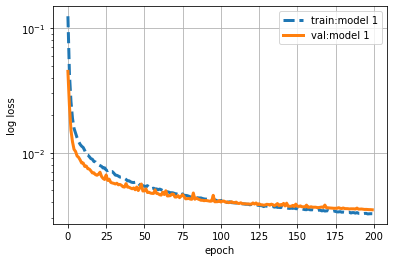

In [7]:

import matplotlib.pyplot as plt
%matplotlib inline

def plot_loss(hist,name,plt,RMSE_TF=False):
    '''
    RMSE_TF: if True, then RMSE is plotted with original scale 
    '''
    loss = hist['loss']
    val_loss = hist['val_loss']
    if RMSE_TF:
        loss = np.sqrt(np.array(loss))*48 
        val_loss = np.sqrt(np.array(val_loss))*48 
        
    plt.plot(loss,"--",linewidth=3,label="train:"+name)
    plt.plot(val_loss,linewidth=3,label="val:"+name)

plot_loss(hist.history,"model 1",plt)
plt.legend()
plt.grid()
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("log loss")
plt.show()

In [8]:
X_test, _ = load(test=True)
y_test = model.predict(X_test)

ImageId    1783
Image      1783
dtype: int64


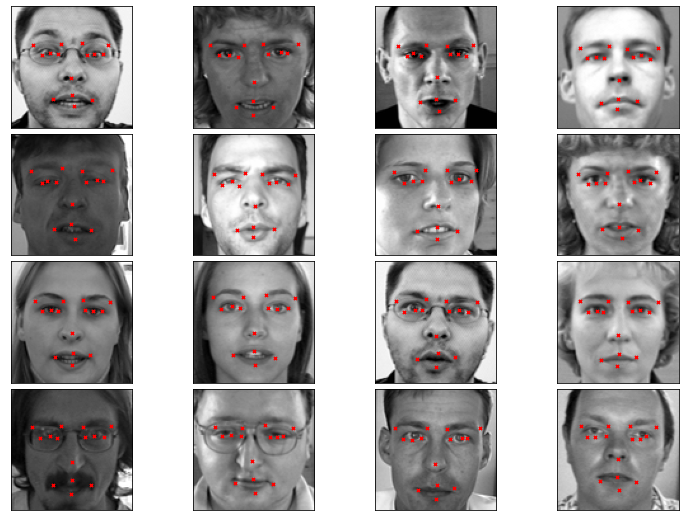

In [9]:
#converting the images back to 96*96 pixels so i can check the performance of my model on the image dataset

def plot_sample(x, y, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10, color='red')


fig = plt.figure(figsize=(10, 7))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    axis = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    plot_sample(X_test[i], y_test[i], axis)

plt.show()

In [10]:
from keras.models import load_model
# import h5py
model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'
# del model  # deletes the existing model

# # returns a compiled model
# # identical to the previous one
model = load_model('my_model.h5')

In [11]:
# #Deleting these as i will use a new structure

del X, y, X_test, y_test

## Convolutional Neural Network

In [12]:
X,y = load2d()

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

In [13]:
print(X.shape)
print(y.shape)

(2140, 96, 96, 1)
(2140, 30)


In [14]:
from keras.layers import MaxPooling2D, Conv2D , Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization


In [15]:
def CNN():
    model2 = Sequential()

    model2.add(Conv2D(filters=16,kernel_size=2,padding="same",activation="relu",input_shape=(96,96,1)))
    model2.add(Dropout(0.1))
    model2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"))
    model2.add(BatchNormalization())

    model2.add(Conv2D(32, 5, 5,activation="relu"))
    # model.add(Activation("relu"))
    model2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"))
    model2.add(Dropout(0.2))
    model2.add(BatchNormalization())

    model2.add(Conv2D(64, 5, 5,activation="relu"))
    # model.add(Activation("relu"))
    model2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"))
    model2.add(BatchNormalization())

    model2.add(Conv2D(128, 3, 3,activation="relu",padding='same'))
    # model.add(Activation("relu"))
    model2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"))
    model2.add(Dropout(0.4))
    model2.add(BatchNormalization())

    model2.add(Flatten())

    model2.add(Dense(500, activation="relu"))
    model2.add(Dropout(0.1))

    model2.add(Dense(128, activation="relu"))
    model2.add(Dropout(0.1))

    model2.add(Dense(30))


    model2.summary()
    model2.compile(optimizer='adam', 
              loss='mse',
              metrics=['mae','accuracy'])
    return(model2)

In [16]:
model2 = CNN()
hist2 = model2.fit(X, y, epochs=200,batch_size=128, validation_split=0.2,verbose=False)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 16)        80        
                                                                 
 dropout_1 (Dropout)         (None, 96, 96, 16)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 16)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 16)       64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 9, 32)          12832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 32)        

In [17]:
print(hist2.history)

{'loss': [0.15724427998065948, 0.04869537428021431, 0.03259854018688202, 0.025426693260669708, 0.020648444071412086, 0.01771930791437626, 0.015832245349884033, 0.014022737741470337, 0.013029779307544231, 0.011996501125395298, 0.011659926734864712, 0.010958610102534294, 0.010005832649767399, 0.010204845108091831, 0.0094600236043334, 0.009088562801480293, 0.008797184564173222, 0.008449851535260677, 0.008440154604613781, 0.008155294694006443, 0.008425870910286903, 0.007848436012864113, 0.007741416804492474, 0.00720231281593442, 0.007316117640584707, 0.0072890217415988445, 0.007014073897153139, 0.006867757998406887, 0.00663704564794898, 0.0069090439938008785, 0.006577054504305124, 0.006738273426890373, 0.006821096409112215, 0.006424217019230127, 0.006278813350945711, 0.006006604991853237, 0.00605833251029253, 0.005931679159402847, 0.0059919110499322414, 0.0059400745667517185, 0.005663784686475992, 0.005811404436826706, 0.005606492981314659, 0.005578670185059309, 0.005572701804339886, 0.005

In [18]:
hist2.history

{'accuracy': [0.20619158446788788,
  0.30490654706954956,
  0.3633177578449249,
  0.4042056202888489,
  0.44392523169517517,
  0.4410046637058258,
  0.47663551568984985,
  0.48714953660964966,
  0.509929895401001,
  0.5233644843101501,
  0.5280373692512512,
  0.5677570104598999,
  0.5619158744812012,
  0.5689252614974976,
  0.6045560836791992,
  0.6045560836791992,
  0.5987149477005005,
  0.6273364424705505,
  0.6466121673583984,
  0.6244158744812012,
  0.6413551568984985,
  0.6512850522994995,
  0.6653037667274475,
  0.6419392228126526,
  0.6653037667274475,
  0.6571261882781982,
  0.6740654110908508,
  0.6699766516685486,
  0.677570104598999,
  0.6752336621284485,
  0.6769859790802002,
  0.6781542301177979,
  0.6875,
  0.6828271150588989,
  0.6904205679893494,
  0.6898364424705505,
  0.6851635575294495,
  0.6921728849411011,
  0.6839953064918518,
  0.6910046935081482,
  0.7009345889091492,
  0.6851635575294495,
  0.6851635575294495,
  0.6921728849411011,
  0.6904205679893494,
  0.693

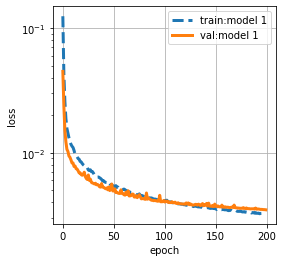

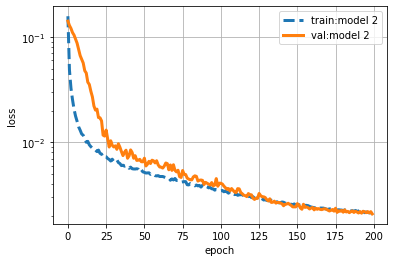

In [19]:
# Comparing model1 and model2
plt.figure(figsize=(4,4))
plot_loss(hist.history,"model 1",plt)
plt.legend()
plt.grid()
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

plot_loss(hist2.history,"model 2",plt)
plt.legend()
plt.grid()
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

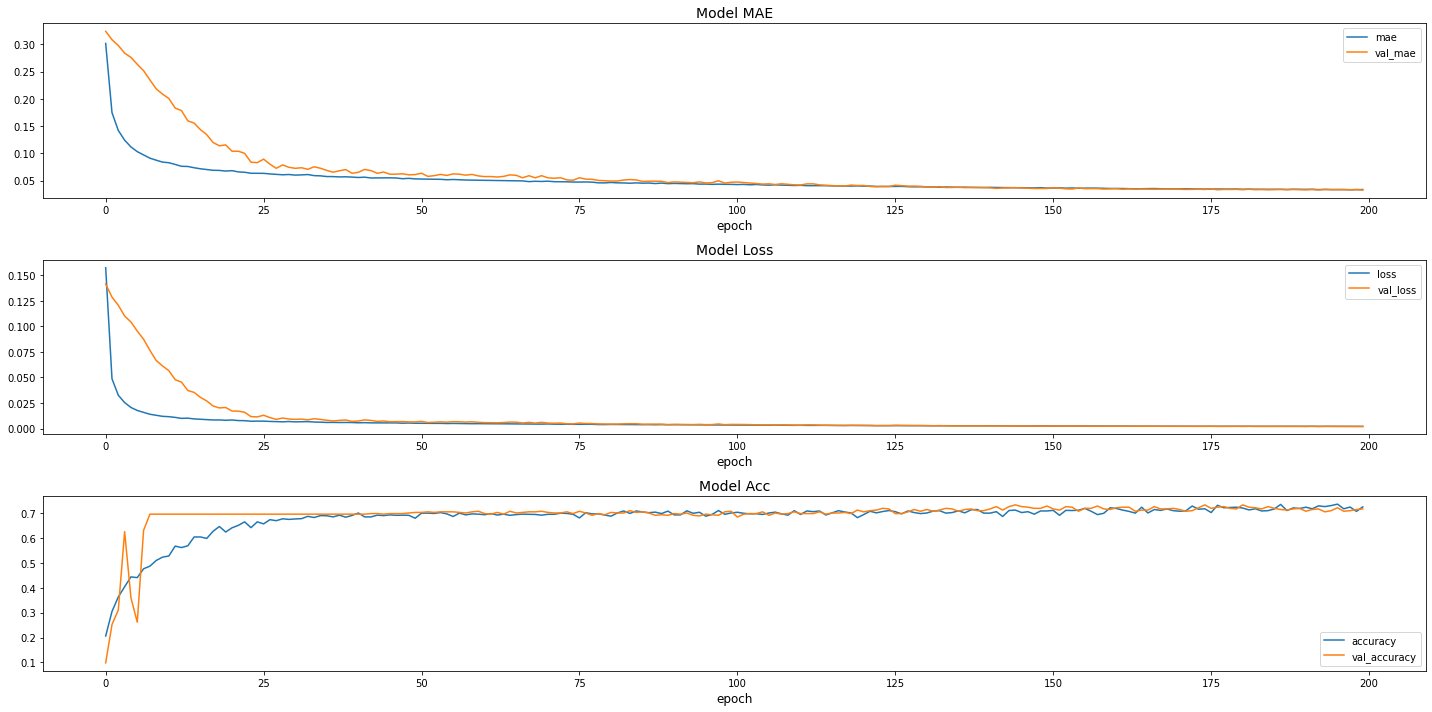

In [20]:
fig, ax = plt.subplots(3, 1, figsize=(20, 10))
df = pd.DataFrame(hist2.history)
df[['mae','val_mae']].plot(ax=ax[0])
df[['loss','val_loss']].plot(ax=ax[1])
df[['accuracy','val_accuracy']].plot(ax=ax[2])
ax[0].set_title('Model MAE', fontsize=14)
ax[0].set_xlabel('epoch', fontsize=12)
ax[1].set_title('Model Loss', fontsize=14)
ax[1].set_xlabel('epoch', fontsize=12)
ax[2].set_title('Model Acc', fontsize=14)
ax[2].set_xlabel('epoch', fontsize=12)
fig.tight_layout()
plt.savefig('D:\\CNN')

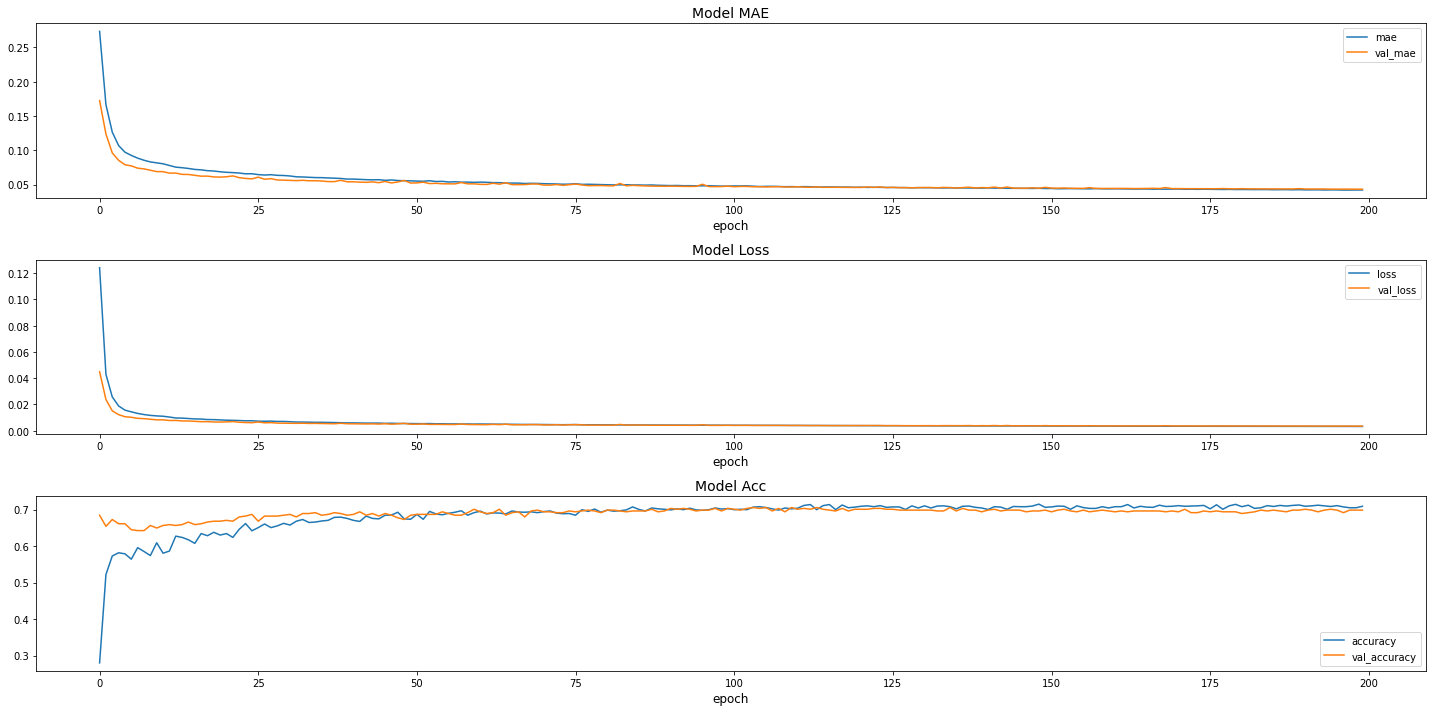

In [21]:
fig, ax = plt.subplots(3, 1, figsize=(20, 10))
df = pd.DataFrame(hist.history)
df[['mae','val_mae']].plot(ax=ax[0])
df[['loss','val_loss']].plot(ax=ax[1])
df[['accuracy','val_accuracy']].plot(ax=ax[2])
ax[0].set_title('Model MAE', fontsize=14)
ax[0].set_xlabel('epoch', fontsize=12)
ax[1].set_title('Model Loss', fontsize=14)
ax[1].set_xlabel('epoch', fontsize=12)
ax[2].set_title('Model Acc', fontsize=14)
ax[2].set_xlabel('epoch', fontsize=12)
fig.tight_layout()
plt.savefig('D:\\SGD')

In [22]:
sample1,_ = load(test=True)
sample2,_ = load2d(test=True)
y_pred1 = model.predict(sample1)
y_pred2 = model2.predict(sample2)

ImageId    1783
Image      1783
dtype: int64
ImageId    1783
Image      1783
dtype: int64


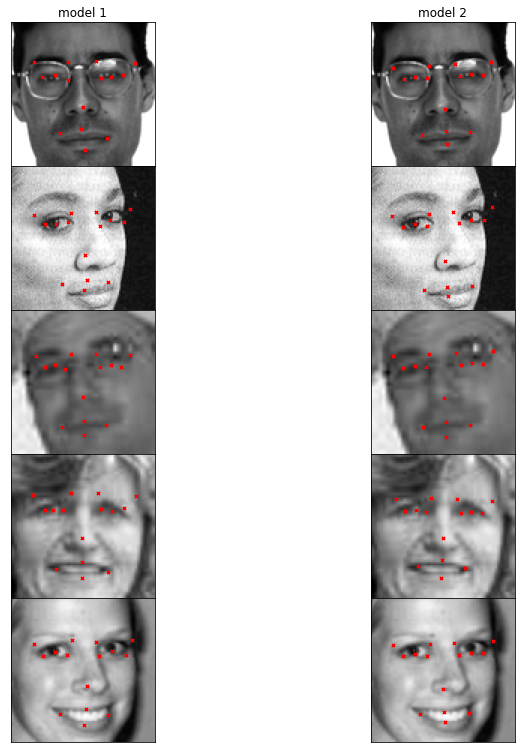

In [23]:
#Comparing model1 and model2 on images

fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(hspace=0.001,wspace=0.001,
                    left=0,right=1,bottom=0, top=1)
Npicture = 5
count = 1
for irow in range(Npicture):
    ipic = np.random.choice(sample2.shape[0])
    ax = fig.add_subplot(Npicture, 2, count,xticks=[],yticks=[])        
    plot_sample(sample1[ipic],y_pred1[ipic],ax)
    if count < 3:
        ax.set_title("model 1")
        
    count += 1
    ax = fig.add_subplot(Npicture, 2, count,xticks=[],yticks=[])  
    plot_sample(sample2[ipic],y_pred2[ipic],ax)
    if count < 3:
        ax.set_title("model 2")
    count += 1
plt.show()

In [24]:
model2.save('my_model2.h5')  # creates a HDF5 file 'my_model.h5'
# del model  # deletes the existing model

# # returns a compiled model
# # identical to the previous one
model2 = load_model('my_model2.h5')

## Argumentation

In [25]:
## Using ImageDataGenerator to flip the images and flip indices will be used to manually flipping
## the keypoints on the face

from keras.preprocessing.image import ImageDataGenerator
class FlippedImageDataGenerator(ImageDataGenerator):
    flip_indices = [
        (0, 2), (1, 3),
        (4, 8), (5, 9), (6, 10), (7, 11),
        (12, 16), (13, 17), (14, 18), (15, 19),
        (22, 24), (23, 25),
        ]

    def next(self):
        X_batch, y_batch = super(FlippedImageDataGenerator, self).next()
        batch_size = X_batch.shape[0]
        indices = np.random.choice(batch_size, batch_size/2, replace=False)
        X_batch[indices] = X_batch[indices, :, :, ::-1]

        if y_batch is not None:
            
            y_batch[indices, ::2] = y_batch[indices, ::2] * -1

            # left_eye_center_x -> right_eye_center_x 
            for a, b in self.flip_indices:
                y_batch[indices, a], y_batch[indices, b] = (
                    y_batch[indices, b], y_batch[indices, a]
                )

        return X_batch, y_batch

In [27]:
## splitting the data
from sklearn.model_selection import train_test_split

X, y = load2d()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

## Transfer learning

In [28]:
SPECIALIST_SETTINGS = [
    dict(
        columns=(
            'left_eye_center_x', 'left_eye_center_y',
            'right_eye_center_x', 'right_eye_center_y',
            ),
        flip_indices=((0, 2), (1, 3)),
        ),

    dict(
        columns=(
            'nose_tip_x', 'nose_tip_y',
            ),
        flip_indices=(),
        ),

    dict(
        columns=(
            'mouth_left_corner_x', 'mouth_left_corner_y',
            'mouth_right_corner_x', 'mouth_right_corner_y',
            'mouth_center_top_lip_x', 'mouth_center_top_lip_y',
            ),
        flip_indices=((0, 2), (1, 3)),
        ),

    dict(
        columns=(
            'mouth_center_bottom_lip_x',
            'mouth_center_bottom_lip_y',
            ),
        flip_indices=(),
        ),

    dict(
        columns=(
            'left_eye_inner_corner_x', 'left_eye_inner_corner_y',
            'right_eye_inner_corner_x', 'right_eye_inner_corner_y',
            'left_eye_outer_corner_x', 'left_eye_outer_corner_y',
            'right_eye_outer_corner_x', 'right_eye_outer_corner_y',
            ),
        flip_indices=((0, 2), (1, 3), (4, 6), (5, 7)),
        ),

    dict(
        columns=(
            'left_eyebrow_inner_end_x', 'left_eyebrow_inner_end_y',
            'right_eyebrow_inner_end_x', 'right_eyebrow_inner_end_y',
            'left_eyebrow_outer_end_x', 'left_eyebrow_outer_end_y',
            'right_eyebrow_outer_end_x', 'right_eyebrow_outer_end_y',
            ),
        flip_indices=((0, 2), (1, 3), (4, 6), (5, 7)),
        ),
    ]

## Training special model with model2

In [29]:
def fit_specialists(freeze=True,
                    print_every=10,
                    epochs=100,
                    prop=0.1,
                    name_transfer_model="my_model2.h5"):
    specialists = OrderedDict()
 

    for setting in SPECIALIST_SETTINGS:
        
        cols = setting['columns']
        flip_indices = setting['flip_indices']
        
        X, y = load2d(cols=cols)
        X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                          test_size=0.2, 
                                                          random_state=42)
        model4 = load_model(name_transfer_model) 
        if freeze:
            for layer in model.layers:
                layer.trainable = False
            
        model4.layers.pop() # get rid of output layer
        model4.outputs = [model4.layers[-1].output]
        model4.layers[-1].outbound_node = []
        model4.add(Dense(len(cols))) # add new output layer

        model4.compile(loss='mean_squared_error', optimizer="adam")
        
        flipgen = FlippedImageDataGenerator()
        flipgen.flip_indices = setting['flip_indices']
        
        print(X_train.shape)
        print(y_train.shape)
        print(X_val.shape)
        print(y_val.shape)
        
        hist_final = model4.fit_generator(flipgen.flow(X_train, y_train),
                                     steps_per_epoch=X_train.shape[0],
                                     epochs=epochs,
                                     validation_data=(X_val, y_val))
        
        
       
        specialists[cols] = model4
    return(specialists)

In [30]:
%%time
from collections import OrderedDict
specialists2 = fit_specialists(freeze=True,
                    print_every=10,
                    epochs=200,
                    name_transfer_model="my_model2.h5")

left_eye_center_x     7039
left_eye_center_y     7039
right_eye_center_x    7036
right_eye_center_y    7036
Image                 7049
dtype: int64
(5626, 96, 96, 1)
(5626, 4)
(1407, 96, 96, 1)
(1407, 4)
Epoch 1/200


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


5626/5626 [==============================] - 3s 302us/step - loss: 0.0445 - val_loss: 0.0115
nose_tip_x    7049
nose_tip_y    7049
Image         7049
dtype: int64
(5639, 96, 96, 1)
(5639, 2)
(1410, 96, 96, 1)
(1410, 2)
Epoch 1/200
5639/5639 [==============================] - 2s 297us/step - loss: 0.0175 - val_loss: 0.0073
mouth_left_corner_x       2269
mouth_left_corner_y       2269
mouth_right_corner_x      2270
mouth_right_corner_y      2270
mouth_center_top_lip_x    2275
mouth_center_top_lip_y    2275
Image                     7049
dtype: int64
(1808, 96, 96, 1)
(1808, 6)
(452, 96, 96, 1)
(452, 6)
Epoch 1/200
1808/1808 [==============================] - 2s 394us/step - loss: 0.1109 - val_loss: 0.0190
mouth_center_bottom_lip_x    7016
mouth_center_bottom_lip_y    7016
Image                        7049
dtype: int64
(5612, 96, 96, 1)
(5612, 2)
(1404, 96, 96, 1)
(1404, 2)
Epoch 1/200
5612/5612 [==============================] - 2s 295us/step - loss: 0.0133 - val_loss: 0.0084
left_eye_in

In [31]:
from pandas import DataFrame, concat
X_test,_ = load2d(test=True)

def predict_specialist(specialists2,X_test):
    y_pred_s = []
    for columns, value in specialists2.items():
        smodel = value

        y_pred = smodel.predict(X_test)
        y_pred = DataFrame(y_pred,columns=columns)
        y_pred_s.append(y_pred)

    df_y_pred_s = concat(y_pred_s,axis=1)
    return(df_y_pred_s)
df_y_pred_s = predict_specialist(specialists2,X_test)
y_pred_s = df_y_pred_s.values

ImageId    1783
Image      1783
dtype: int64


In [32]:
## prediction with model 2
y_pred2 = model2.predict(X_test)
landmark_nm = read_csv(os.path.expanduser(FTRAIN)).columns[:-1].values
df_y_pred2 = DataFrame(y_pred2,columns = landmark_nm)

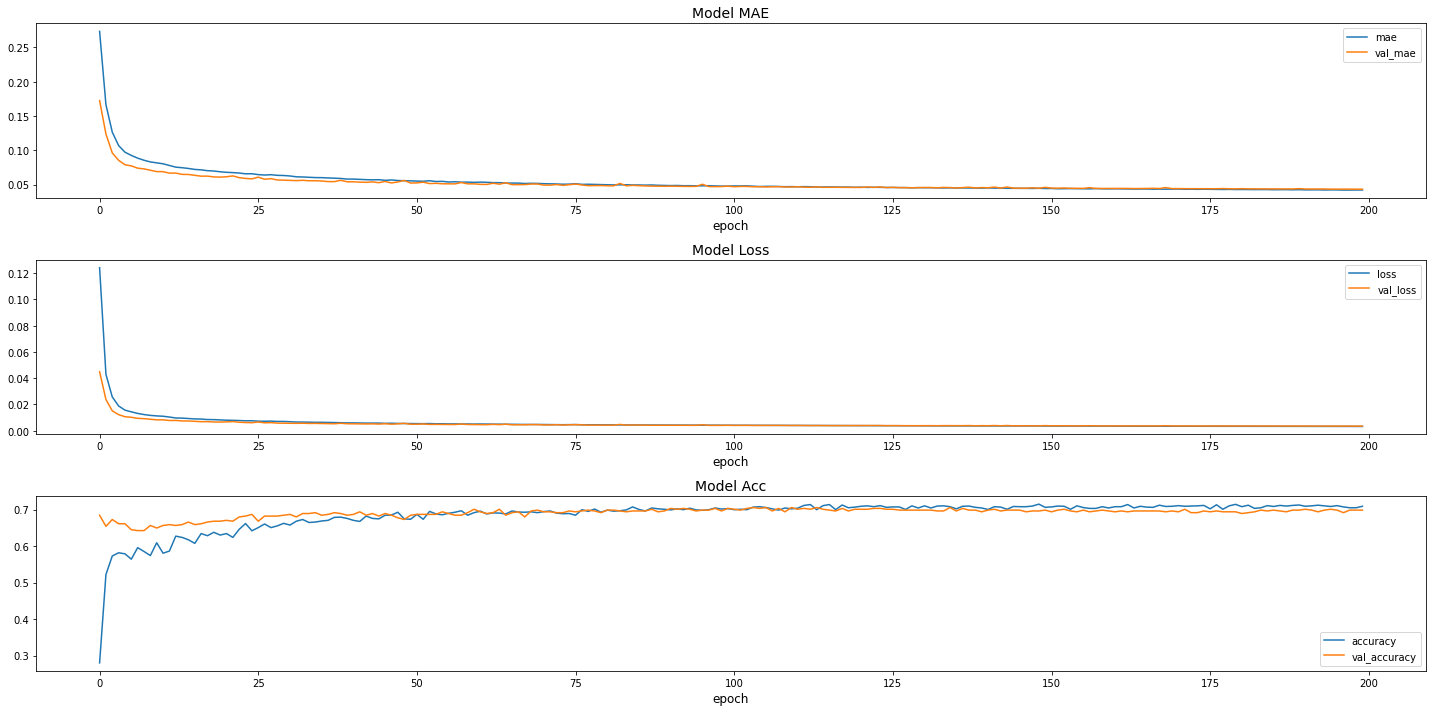

In [36]:
fig, ax = plt.subplots(3, 1, figsize=(20, 10))
df = pd.DataFrame(hist.history)
df[['mae','val_mae']].plot(ax=ax[0])
df[['loss','val_loss']].plot(ax=ax[1])
df[['accuracy','val_accuracy']].plot(ax=ax[2])
ax[0].set_title('Model MAE', fontsize=14)
ax[0].set_xlabel('epoch', fontsize=12)
ax[1].set_title('Model Loss', fontsize=14)
ax[1].set_xlabel('epoch', fontsize=12)
ax[2].set_title('Model Acc', fontsize=14)
ax[2].set_xlabel('epoch', fontsize=12)
fig.tight_layout()
plt.savefig('D:\\Tramsfer')